In [1]:
!pip install gdown
!pip install rarfile
!pip install tensorflow

In [2]:
import gdown
import os
import pandas as pd
import rarfile
from sklearn.model_selection import train_test_split
base_dir='https://drive.google.com/uc?id=1H4faRA0bCQYxUU5ScMWn0GjsgRsbDLF_'
output_rar = '/content/Brain Tumor MRI Dataset.rar'
gdown.download(base_dir,output_rar,quiet=False)
with rarfile.RarFile(output_rar,'r') as rar_ref:
  rar_ref.extractall('/content/')

Downloading...
From (original): https://drive.google.com/uc?id=1H4faRA0bCQYxUU5ScMWn0GjsgRsbDLF_
From (redirected): https://drive.google.com/uc?id=1H4faRA0bCQYxUU5ScMWn0GjsgRsbDLF_&confirm=t&uuid=87daa3f6-6447-442f-8303-1de78bdb5f29
To: /content/Brain Tumor MRI Dataset.rar
100%|██████████| 156M/156M [00:03<00:00, 51.4MB/s]


In [3]:
dataset='/content/Brain Tumor MRI Dataset'

In [4]:
test=os.path.join(dataset,'Test')
train=os.path.join(dataset, 'Train')
validate=os.path.join(dataset,'Validate')
print(f"data set {dataset}")
print(f" validate {validate}")
print(f"Train Path: {dataset}")
# Run this command to check if the path exists:
!ls "{train}"

data set /content/Brain Tumor MRI Dataset
 validate /content/Brain Tumor MRI Dataset/Validate
Train Path: /content/Brain Tumor MRI Dataset
glioma	meningioma  notumor  pituitary


In [5]:
!ls "/content/Brain Tumor MRI Dataset"

Test  Train  Validate


In [6]:
import cv2
import numpy as np

def preprocess_image(image_path, image_size=(224,224)):
    # CLAHE + Morphology
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)
    _, mask = cv2.threshold(img_clahe, 10, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    img_result = cv2.bitwise_and(img_clahe, img_clahe, mask=mask)
    img_result = cv2.resize(img_result, image_size)
    img_result = cv2.cvtColor(img_result, cv2.COLOR_GRAY2RGB)
    return img_result / 255.0


In [7]:
import os

def preprocess_folder(src_folder, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)
    for class_name in os.listdir(src_folder):
        src_class = os.path.join(src_folder, class_name)
        dest_class = os.path.join(dest_folder, class_name)
        os.makedirs(dest_class, exist_ok=True)
        for img_name in os.listdir(src_class):
            src_img_path = os.path.join(src_class, img_name)
            dest_img_path = os.path.join(dest_class, img_name)
            img = preprocess_image(src_img_path)
            # Convert back to BGR for saving
            cv2.imwrite(dest_img_path, cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2BGR))


In [8]:
train_pre = os.path.join(dataset, 'Train_pre')
validate_pre = os.path.join(dataset, 'Validate_pre')
test_pre = os.path.join(dataset, 'Test_pre')

preprocess_folder(train, train_pre)
preprocess_folder(validate, validate_pre)
preprocess_folder(test, test_pre)


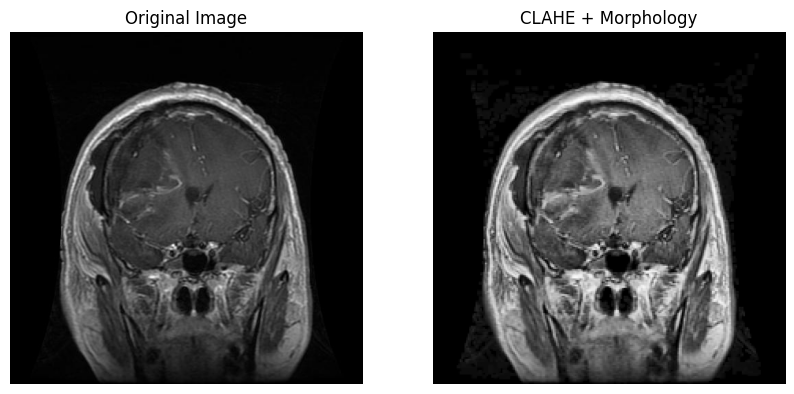

In [9]:
import matplotlib.pyplot as plt
import os
import cv2
example_path = os.path.join(train, 'glioma', os.listdir(os.path.join(train, 'glioma'))[0])

img_original = cv2.imread(example_path)
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

img_processed = preprocess_image(example_path)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_original_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_processed)
plt.title("CLAHE + Morphology")
plt.axis('off')

plt.show()


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=(224,224)
BATCH_size=32
num_of_classes=4
train_data_gen=ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest' )
val_test_gen=ImageDataGenerator(rescale=1./255)
train_generator=train_data_gen.flow_from_directory(
    train,
    target_size=image_size,
    batch_size=BATCH_size,
    class_mode='categorical'
)
validation_gen=val_test_gen.flow_from_directory(
    validate,
    target_size=image_size,
    batch_size=BATCH_size,
    class_mode='categorical'
)
test_gen=val_test_gen.flow_from_directory(
    test,
    target_size=image_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 658 images belonging to 4 classes.
Found 653 images belonging to 4 classes.


In [11]:
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D ,Flatten,MaxPool2D,Dense, GlobalAveragePooling2D, Dropout
inception_base=InceptionV3(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
model=models.Sequential([
    inception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_of_classes,activation='softmax')
])
model.summary()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']

)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,116,580 (88.18 MB)

 Trainable params: 23,082,148 (88.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.5070 - loss: 1.1624
Epoch 1: val_accuracy improved from -inf to 0.22948, saving model to /content/drive/MyDrive/brain_tumor_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 252s 905ms/step - accuracy: 0.5075 - loss: 1.1620 - val_accuracy: 0.2295 - val_loss: 6.5587
Epoch 2/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.5136 - loss: 1.3824
Epoch 2: val_accuracy improved from 0.22948 to 0.40122, saving model to /content/drive/MyDrive/brain_tumor_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 98s 549ms/step - accuracy: 0.5139 - loss: 1.3810 - val_accuracy: 0.4012 - val_loss: 2.8406
Epoch 3/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.6542 - loss: 0.8346
Epoch 3: val_accuracy improved from 0.40122 to 0.49088, saving model to /content/drive/MyDrive/brain_tumor_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 560ms/step - accuracy: 0.6543 - loss: 0.8345 - val_accuracy: 0.4909 - val_loss: 1.6764
Epoch

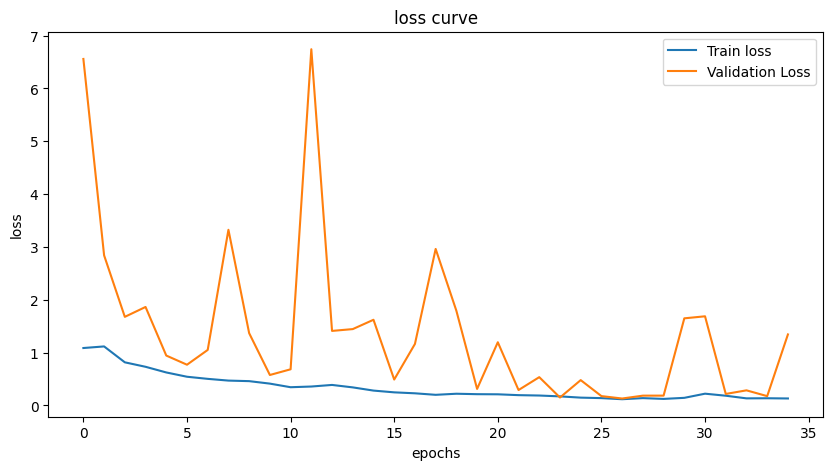

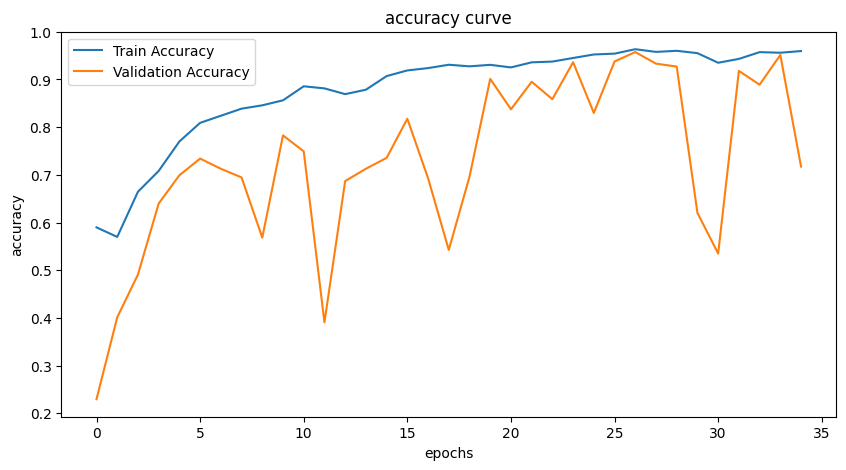

653/653 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step


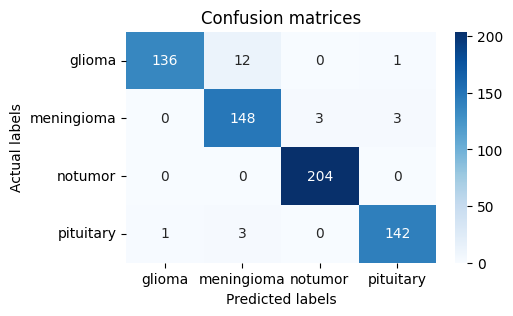

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.91      0.95       149
  meningioma       0.91      0.96      0.93       154
     notumor       0.99      1.00      0.99       204
   pituitary       0.97      0.97      0.97       146

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.97      0.96      0.96       653

 Overall accuracy  0.9647779479326187
653/653 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step

Performence on test data
Precision: 0.965978725695083
Recall: 0.9647779479326187
F1 Score: 0.9648014546200977
Accuracy: 0.9647779479326187
            glioma  meningioma  notumor  pituitary
glioma         136          12        0          1
meningioma       0         148        3          3
notumor          0           0      204          0
pituitary        1           3        0        142

Class: glioma
TP: 1, FN: 0, FP: 12, TN: 136
Precision: 0.08
Recal

In [13]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import (precision_score,
                             recall_score,f1_score,
                             confusion_matrix,accuracy_score,
                             classification_report,
                             multilabel_confusion_matrix)
epoch=35

best_weight_path='/content/drive/MyDrive/brain_tumor_best_model.keras'
checkpoint=ModelCheckpoint(
   best_weight_path,monitor="val_accuracy",verbose=1,
   save_best_only=True,mode='max'
)
history=model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_gen,
    callbacks=[checkpoint],
    verbose=1
)

plt.figure(figsize=(10,5))
plt.plot(history.history["loss"],label="Train loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("loss curve")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"],label="Train Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.title("accuracy curve")
plt.show()
classes=['glioma','meningioma','notumor','pituitary']

model=tf.keras.models.load_model(best_weight_path)
predictions=model.predict(test_gen)
predict_classes=np.argmax(predictions,axis=1)
true_classes=test_gen.classes


cm=confusion_matrix(true_classes,predict_classes)
plt.figure(figsize=(5,3))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=classes,yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion matrices')
plt.show()


report=classification_report(true_classes,predict_classes,target_names=classes)
print("Classification Report:\n", report)
accuracy=np.sum(predict_classes==true_classes)/len(true_classes)
print(" Overall accuracy ",accuracy)
classes=['glioma','meningioma','notumor','pituitary']

def evaluate_model(test_data,model,classes,title="Performance"):
  y_pred_class=np.argmax(model.predict(test_data),axis=1)
  precision=precision_score(test_data.labels,y_pred_class,average="weighted")
  recall=recall_score(test_data.labels,y_pred_class,average="weighted")
  f1=f1_score(test_data.labels,y_pred_class,average="weighted")
  accuracy=accuracy_score(test_data.labels,y_pred_class)

  print(f"\n{title}")
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("Accuracy:", accuracy)

  confusion=confusion_matrix(test_data.labels,y_pred_class)
  format=pd.DataFrame(confusion,index=classes,columns=classes)
  print(format)
  cm=confusion_matrix(test_data.labels,y_pred_class)
  for idx,name_class in enumerate(classes):
    tn,fp,fn,tp=cm[idx].ravel()
    precision=tp/(tp+fp) if (tp+fp) > 0 else 0
    recall=tp/(tp+fn) if (tp+fn) > 0 else 0
    class_f1_score=(2*precision * recall)/(precision+recall) if (precision+recall) > 0 else 0

    print(f"\nClass: {name_class}")
    print(f"TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {class_f1_score:.2f}")
evaluate_model(
    test_gen,
    model,
    classes,
    title="Performence on test data"
)

